In [1]:
import numpy as np
from scipy import signal, ndimage
import matplotlib.pyplot as plt
from librosa import load, to_mono
from librosa.output import write_wav
import noisereduce as nr
from skimage.morphology import remove_small_objects
from more_itertools import consecutive_groups
import os
from scipy.signal import butter, lfilter
from collections import OrderedDict

/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Module

In [2]:
def plotter(
    spectrogram,
    title=None,
    upside_down = False,
    db=False, #db transform the spect
    fig_size=(15, 15), #Without this, just plots without a figsize
):
    # Plot, flip the y-axis
    if fig_size:
        fig, ax = plt.subplots(1, figsize=fig_size)
    else:
        fig, ax = plt.subplots(1)#, figsize=(10, 10))
    if db:
        ax.imshow(power_to_db(spectrogram), cmap=plt.get_cmap("gray_r"))
    else:
        ax.imshow(spectrogram, cmap=plt.get_cmap("gray_r"))
    if upside_down:
        ax.set_ylim(ax.get_ylim()[::-1])
    if title:
        ax.set_title(title)
    ax.set_aspect(spectrogram.shape[1] / (3*spectrogram.shape[0]))

    plt.show()

# Make spectrogram

### Module

In [3]:
def load_file(filename, sample_rate=22050):
    '''
    Load samples from an audio file
    
    Inputs:
        filename: path to audio file from which to make spectrogram (optional)
        sample_rate: rate at which to resample audio
    
    Returns:
        samples: the samples from the wav file
        sample_rate: the sample rate from the wav file
    '''
    
    samples, sample_rate = load(
        filename,
        mono=False,  # Don't automatically load as mono, so we can warn if we force to mono
        sr=sample_rate, # Resample
        res_type='kaiser_best',
    )
    
    # Force to mono if wav has multiple channels
    if samples.ndim > 1:
        samples = to_mono(samples)
        print(
            f"WARNING: Multiple-channel file detected ({filename}). Automatically mixed to mono."
        )
        
    return samples, int(sample_rate)


def make_spect(samples, samples_per_seg, overlap_percent, sample_rate=22050):
    '''
    Make spectrogram from an audio file
    
    If filename is provided, uses librosa to load samples from filename. Else,
    preloaded_samples must be provided; will generate a spectrogram from these samples
    
    Inputs:
        samples: mono samples loaded from an audio file
        samples_per_seg: window size for spectrogram
        overlap_percent: overlap percent for spectrogram (between 0 and 1)
        sample_rate: sample rate for audio
        preloaded_samples: (optional) already-loaded samples
    
    Returns:
        frequencies - sample frequencies
        times - time for each segment
        spectrogram - spectrogram values
    '''

    
    overlap_per_seg = samples_per_seg * overlap_percent

    frequencies, times, spectrogram = signal.spectrogram(
        samples,
        sample_rate,
        window='hann',
        nperseg=samples_per_seg,
        noverlap=overlap_per_seg,
        nfft=512)
    
    return frequencies, times, spectrogram

### Calls

In [35]:
filename = '/Volumes/seagate3/xeno-canto/20181207/cardinalis-cardinalis/mp3s/97364.mp3'
base_dir = '/Volumes/seagate3/project-data/10birds-data'

# Place to store the results
split = filename.split('/')
species = split[5]
cat_num = os.path.splitext(split[7])[0] #splitext removes the .mp3
base_dir_1 = os.path.join(base_dir, species)
try: os.mkdir(base_dir_1)
except FileExistsError:
    pass


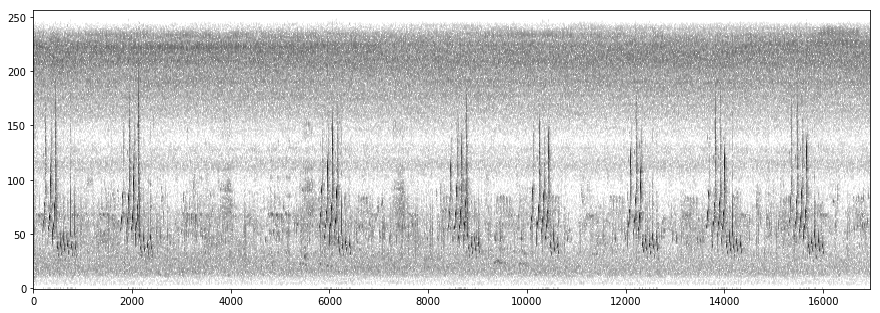

In [36]:
samples_per_seg = 512
overlap_percent = 0.75
sample_rate = 22050.0

samples, sample_rate = load_file(
    filename = filename,
    sample_rate = sample_rate)

freqs, times, spect = make_spect(
    samples = samples,
    samples_per_seg = samples_per_seg,
    overlap_percent = overlap_percent,
    sample_rate = sample_rate)

from librosa.core import power_to_db
plotter(power_to_db(spect), upside_down=True)

# Remove undesired frequency bins

### Module

In [6]:
def spectrogram_bandpass(spectrogram, frequencies, low_freq, high_freq):
    '''
    Perform a "bandpass" filter on a spectrogram
    
    Performs a "bandpass" filter on a spectrogram using the 
    array of frequencies associated with each sample on the spectrogram.
    Finds the indices of the desired frequencies with respect
    to the array of frequencies.
    
    
    Inputs:
        spectrogram: the spectrogram image
        frequencies: sample frequencies
        low_freq: the lowest frequency to keep
        high_freq: the highest frequency to keep
        
    Returns:
        a new spectrogram
        a new array of sample frequencies
    '''

    frequency_filter_indices = np.argwhere(
        (frequencies >= low_freq) & 
        (frequencies <= high_freq)
    ).flatten()
    
    new_frequencies = frequencies[frequency_filter_indices]
    new_spectrogram = spectrogram[frequency_filter_indices, :]
    
    return new_spectrogram, new_frequencies

### Calls

In [7]:
#low_frequency_thresh = 173
#high_frequency_thresh = 10033
#spect, f = spectrogram_bandpass(spect, f, low_frequency_thresh, high_frequency_thresh)
#plotter(power_to_db(spect), upside_down=True)

# Normalize spectrogram

### Module

In [8]:
def normalize_spect(spectrogram):
    '''
    Complete a simple value normalization of a spectrogram
    '''
    

    # Simple Normalization (this also flips the image)
    spectrogram_max = spectrogram.max()
    spectrogram = spectrogram / spectrogram_max
    
    # Flip image back to correct orientation
    spectrogram = np.flip(spectrogram, 0)
    
    return spectrogram

### Calls

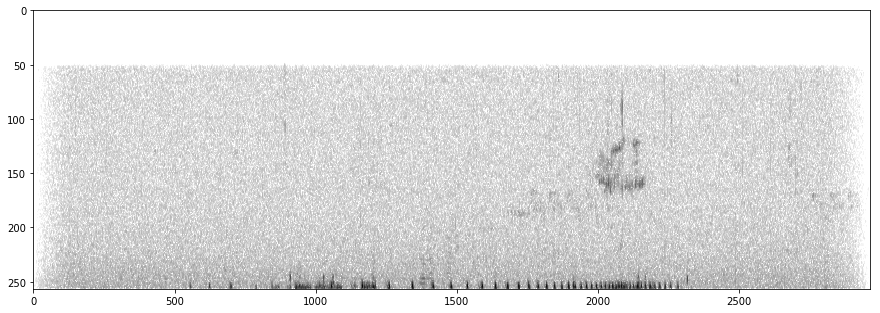

In [9]:
normalized_spect = normalize_spect(spect)
plotter(power_to_db(normalized_spect))

# Median filter

### Module

In [10]:
def binarize_by_median(spectrogram, multiplier=9.0):
    '''
    Zeroes out spectrogram values below median * multiplier
    '''
    
    # removeNoisePerFreqBandAndTimeFrame
    def _filter_by_scaled_median(arr, factor=multiplier):
        _temp = np.copy(arr)
        median = factor * np.median(_temp)
        for i, val in enumerate(_temp):
            if val < median:
                _temp[i] = 0.0
        return _temp
    
    row_median_filtered = np.apply_along_axis(_filter_by_scaled_median, 0, spectrogram)
    column_median_filtered = np.apply_along_axis(_filter_by_scaled_median, 1, spectrogram)
    
    return np.logical_and(row_median_filtered, column_median_filtered)

### Calls

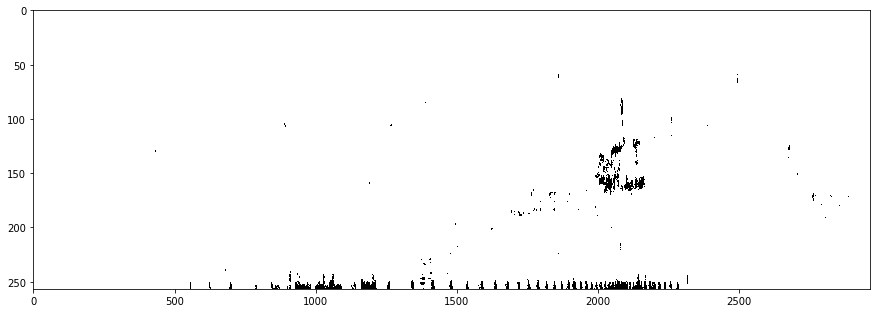

In [11]:
median_binarize_multiplier = 20.0
#median_binarize_multiplier = 9.0
binary_spect = binarize_by_median(normalized_spect, multiplier = median_binarize_multiplier)
plotter(binary_spect)

# Image processing on spectrogram

### Module

In [12]:
def image_processing_dict(
    spectrogram, 
    params = OrderedDict({
    'binary_closing':(6, 10),
    'binary_dilation':(3, 5), 
    'median_filter':(5, 3),
    'small_objects':25,
}),
    plot_func = None):
    
    '''
    Use 4 noise reduction algorithms
    
    Inputs: (defaults are as in Barry Moore's original code)
        spectrogram: the spectrogram
        params: OrderedDict where the order of the keys specifies the order 
            of the functions, and the values specify the parameters for the functions.
        plot_func:  function to use to display spectrograms.
            Should take keyword arguments `spectrogram`, `title`
            If not provided, spectrograms will not be plotted
    
    Defaults
    '''
    from collections import OrderedDict
    
    if plot_func == None:
        def plot_func(*args, **kwargs):
            return None
    
    # Create wrapper functions to supply params as simple ordered args
    def binary_closing(spect, struct):
        return ndimage.morphology.binary_closing(spect, structure = np.ones(struct))
    def binary_dilation(spect, struct):
        return ndimage.morphology.binary_dilation(spect, structure = np.ones(struct))
    def median_filter(spect, size):
        return ndimage.median_filter(spect, size = median_filter_size)
    def small_objects(spect, size):
        return remove_small_objects(spect, size)
    
    # Translate keys to actual functions
    funcs = {
        'binary_closing':binary_closing,
        'binary_dilation':binary_dilation,
        'median_filter':median_filter,
        'small_objects':small_objects
    }
    
    # Input validation
    assert(set(params.keys()).issubset(funcs.keys()))
    
    # Go through the steps in order (ordered b/c params is an OrderedDict)
    result = spectrogram
    for step in params.keys():
        func = funcs[step]
        result = func(result, params[step])
        title = f'{step}, {params[step]}'
        plot_func(spectrogram = result, title = title, fig_size=(10, 10))
    return result

### Calls

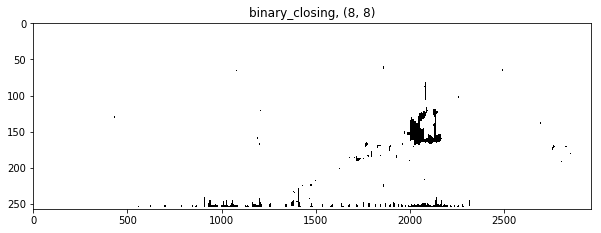

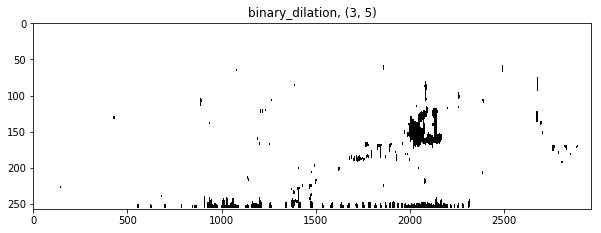

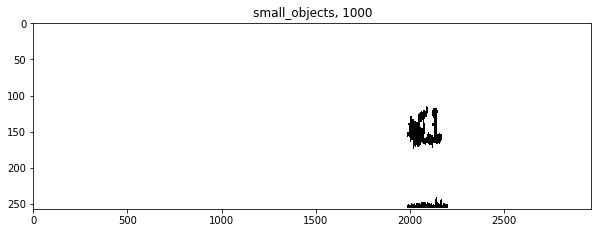

In [13]:
from collections import OrderedDict

small_obj_size = 1000
binary_closing_size = (8 , 8)
binary_dilation_size = (3, 5)

desired_steps = OrderedDict({
    'binary_closing':binary_closing_size,
    'binary_dilation':binary_dilation_size,
    'small_objects':small_obj_size
})

binary_processed = image_processing_dict( 
    spectrogram = binary_spect,
    params = desired_steps,
    plot_func = plotter
)

# Noise reduction

### Module

In [14]:
def box_binary(spectrogram_binary):
    '''
    Identify boxes in a binary spectrogram
    '''
    # Label sub-segments on binary spectrogram
    binary_labeled, num_bin_segments = ndimage.label(spectrogram_binary)
    
    # Put a box around each labeled sub-segment
    bounding_boxes = ndimage.find_objects(binary_labeled)

    # Convert boxes, which are slices, to nice lists
    for idx, slice_box in enumerate(bounding_boxes):
        bounding_boxes[idx] = [slice_box[0].start, slice_box[0].stop, slice_box[1].start, slice_box[1].stop]
    
    plotter(spectrogram = binary_labeled, title = f'{num_bin_segments} segments identified:')
    
    return bounding_boxes


In [15]:
def wav_writer(samples, sample_rate, suffix, orig, newdir=None, subdir=None, verbose=True):
    '''
    Saves a wav in same place as original .wav file
    
    Inputs:
        samples: new samples to save
        orig: original filename of .wav file
        suffix: suffix for the new filename
        newdir: a new directory to use instead of the original wav file's path
        subdir: name of a subdirectory to make in the original or new directory
        
    Returns:
        the new filename
    '''
    
    filesplit = os.path.split(orig)
    
    # Get the path in which to save the wav
    if newdir:
        base_path = newdir
    else:
        base_path = filesplit[0] #Same path as the original file
    
    if subdir:
        base_path = os.path.join(base_path, subdir)
    
    # Make path if necessary
    try: 
        os.mkdir(base_path)
    except FileExistsError:
        pass
    
    # Get the name by which to save the wav
    file_name = filesplit[1]
    base_name = f'{os.path.splitext(file_name)[0]}_{suffix}.wav'
    
    # Full path & filename by which wav should be saved
    file_path = os.path.join(base_path, base_name)
    
    write_wav(file_path, np.array(samples), sample_rate)
    if verbose: print(f'Saved files to {file_path}')
    
    return file_path

In [16]:
def box_to_ft(box, freqs, times, sr):
    '''
    Convert an np box to freq/time
    
    Inputs:
        box (array): [low_freq_np, high_freq_np, start_time, end_time]
        times (array): array of times where times[start_time] = the desired start time
        freqs (array): array of freqs where freqs[len(freqs) - low_freq_np] = the desired frequency
            i.e. frequencies are a reversed list of what frequency each window in the np spectrogram belongs to
    
    Returns:
        array: [low_freq, high_freq, start_sample, end_sample]
    '''
    
    low_freq = freqs[len(freqs)-box[0]-1]
    high_freq = freqs[len(freqs)-box[1]-1]
    start_sample = int(round(times[box[2]-1] * sr)) #*(2-overlap_percent)*100)
    end_sample = int(round(times[box[3]-1] * sr)) #int(box[3]*(2-overlap_percent)*100)
    
    return [low_freq, high_freq, start_sample, end_sample]
    

In [17]:
def save_noise_file(binary_spectrogram, bounding_boxes, original_filename, samples, freqs, times, sr, newdir=None, subdir=None):
    '''
    Save a file containing the noise
    
    Inputs:
        binary_spectrogram: a 0/1 spectrogram
        bounding_boxes: boxes around detections in binary spect
        original_filename: original filename of the file
        samples: samples from original file
        freqs: frequency list for the original spect used to generate bounding boxes
        times: time list for the original spect used to generate bounding boxes
        sr: sample rate
        newdir: a place to save new files (by default, saves in same dir as original_filename)
        subdir: a subdirectory in which to save new files 
            if subdir = None, just saves in the behavior determined by newdir's presence or absence
            if subdir == 'orig', saves in a directory named after original_filename
        
    Returns:
        new_filename (string): a path to the filename of the noise file
    '''
    
    # Convert bounding boxes to frequency/sample # boxes
    ft_boxes = []
    for box in bounding_boxes:
        ft_boxes.append(box_to_ft(box, freqs, times, sr))

    # Create list of samples identified as noise (True) or not (False)
    use_as_noise_samples = np.full(samples.shape[0], True, dtype=bool)
    for ft_box in ft_boxes:
        time_start = ft_box[2]
        time_end = ft_box[3]
        use_as_noise_samples[time_start:time_end] = False

    # Create list of x boundaries for noisy spots
    data = np.where(use_as_noise_samples)[0] #indices where noise == True
    start_end_samples = []
    for group in consecutive_groups(data):
        group_list = list(group)
        start_end_samples.append([group_list[0], group_list[-1]])
    
    
    # Write noise to file
    noise_data = []
    detection_data = []
    for idx in range(len(start_end_samples)):
        # Append samples from the current noise
        noise_start = int(start_end_samples[idx][0])
        noise_stop = int(start_end_samples[idx][1])
        noise_data.extend(samples[noise_start:noise_stop])

        # Append samples from the previous detection
        if noise_start > 0:
            # For sounds at the beginning of the file
            if idx == 0:
                detection_data.extend(samples[0:noise_start])

            # For sounds between two noises
            else:
                sound_start = int(start_end_samples[idx-1][1])
                sound_end = noise_start
                detection_data.extend(samples[sound_start:sound_end])

    # Write wavs and store their filenames
    if subdir=='orig':
        subdir = os.path.splitext(os.path.basename(original_filename))[0]
    noise_filename = wav_writer(noise_data, sr, suffix='noise', orig = original_filename, subdir=subdir, newdir=newdir)
    detections_filename = wav_writer(detection_data, sr, suffix='detections', orig = original_filename, subdir=subdir, newdir=newdir)

    return noise_filename


### Calls

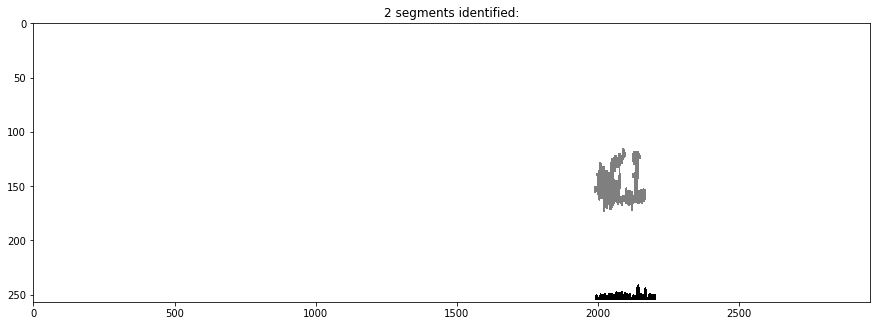

Saved files to /Volumes/lacie/10birds-data/bonasa-umbellus/77993/77993_noise.wav
Saved files to /Volumes/lacie/10birds-data/bonasa-umbellus/77993/77993_detections.wav


In [18]:
bounding_boxes = box_binary(binary_processed)
noise_filename = save_noise_file(
    binary_spectrogram=binary_processed,
    bounding_boxes=bounding_boxes,
    original_filename=filename,
    samples = samples,
    freqs = freqs,
    times = times,
    sr = sample_rate,
    newdir = save_dir,
    subdir = cat_num
)

### Module

In [19]:
def audacity_noise_reduce(noise_file, audio_samples, verbose=False):
    '''
    Uses a sample file of noise to noise-reduce like Audacity does
    
    Inputs:
        noise_file: path to noise file
        audio_samples: samples to be noise-reduced
        verbose: whether or not to print graphs
    
    Returns: 
        noise-reduced samples.
        for some reason makes a smaller spectrogram? #TODO
    '''
    
    noise_samples, sample_rate = load(
        noise_file,
        mono=False,  # Don't automatically load as mono, so we can warn if we force to mono
        sr=22050.0, # Resample
        res_type='kaiser_best',
    )
    # perform noise reduction
    reduced_noise_samples = nr.reduce_noise(audio_clip=audio_samples, noise_clip=noise_samples, verbose=verbose)

    
    return reduced_noise_samples


### Calls

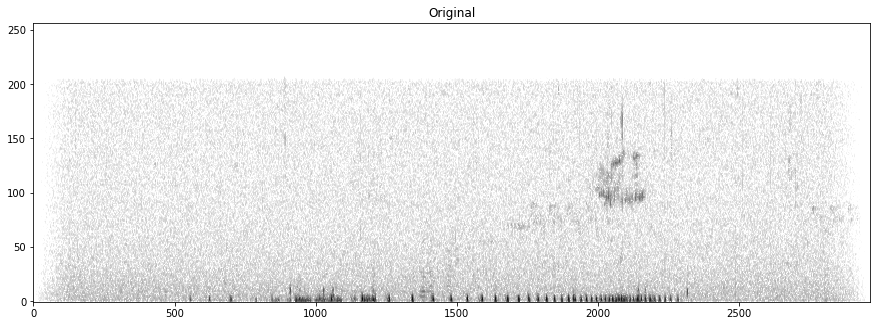

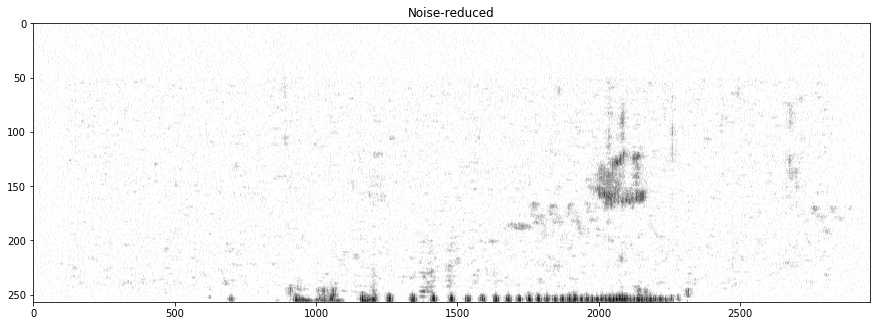

In [20]:
samples_nr = audacity_noise_reduce(noise_file=noise_filename, audio_samples=samples)
freqs_nr, times_nr, spect_nr = make_spect(samples_nr, samples_per_seg=samples_per_seg, overlap_percent=overlap_percent)
spect_nr = normalize_spect(spect_nr)
plotter(spect, db=True, upside_down=True, title='Original')
plotter(spect_nr, db=True, title='Noise-reduced')

# Save denoised sound file

### Calls

In [21]:
cat_num = os.path.split(filename)[1].split('.')[0]
wav_writer(
    samples = samples_nr,
    orig = cat_num,
    sample_rate = sample_rate,
    newdir = save_dir,
    subdir = cat_num,
    suffix='denoised')

Saved files to /Volumes/lacie/10birds-data/bonasa-umbellus/77993/77993_denoised.wav


'/Volumes/lacie/10birds-data/bonasa-umbellus/77993/77993_denoised.wav'

# Save detection segments

### Module

In [22]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    Wn = [low, high]
    if low == 0:
        low = 0.00001
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Calls

In [23]:
for idx, box in enumerate(bounding_boxes):
    # convert box, which is in terms of numpy array, to sample number and frequency number
    high_freq, low_freq, start_sample, end_sample = box_to_ft(box, freqs_nr, times, sample_rate) #Note: times_nr results in out of bounds

    # extract those samples from the audio
    segment_samples = samples_nr[start_sample: end_sample]

    # bandpass filter the samples above and below the box limits
    filtered_samples = butter_bandpass_filter(segment_samples, low_freq, high_freq, sample_rate)

    # save samples
    wav_writer(
        filtered_samples, 
        orig = cat_num,
        sample_rate = sample_rate,
        newdir = save_dir,
        subdir = cat_num,
        suffix = f'detection{idx}'
    )

Saved files to /Volumes/lacie/10birds-data/bonasa-umbellus/77993/77993_detection0.wav
Saved files to /Volumes/lacie/10birds-data/bonasa-umbellus/77993/77993_detection1.wav


# Rerun image processing on noise-reduced?

    median_binarize_multiplier = 9.0
    binarized_rn = binarize_by_median(spect_nr, multiplier = median_binarize_multiplier)
    plotter(binarized_rn, fig_size=(10,10))

    binary_closing_size = (1, 1)
    binary_dilation_size = (10, 10)
    median_filter_size = (3, 3)
    small_obj_size = 1000
    arguments = {'fig_size':(10, 10)}

    noise_reduced_rn = image_processing( 
        spectrogram = binarized_rn, 
        binary_closing_size = binary_closing_size,
        binary_dilation_size = binary_dilation_size,
        median_filter_size = median_filter_size,
        small_obj_size = small_obj_size,
        plot_func = plotter
    )

# Identify segments

### Module

In [24]:
def identify_segments(
    spectrogram_original,
    spectrogram_processed,
    bounding_boxes,
    margin = 2,
    method = None,
    plot_func = None
):
    '''
    Break spectrogram into segments
    
    Inputs:
        spectrogram_original: the original raw spectrogram from which to pull segments
        spectrogram_processed: a binarized, noise-reduced spectrogram
        bounding_boxes: 
        margin: approximate pixel margin around each detection;
            detections closer than this margin will be considered one segment
        method: 'min' or None. 
            - if 'min', will replace non-needed values with a minimum 
              (return a spect that blends in to background)
            - otherwise, will return a spect where detections don't blend in 
              with background (background will be np.nans)
        plot_func: function to use to display spectrograms.
            Should take keyword arguments `spectrogram`, `title`
            If not provided, spectrograms will not be plotted
        
    '''  

    # Iteratively add boxes to spect
    box_image = np.full(spectrogram_processed.shape, 0)
    for b in bounding_boxes:
        y_min = b[0] - margin
        y_max = b[1] + margin
        x_min = b[2] - margin
        x_max = b[3] + margin
        box_image[y_min:y_max, x_min:x_max] = 1
        
    # Label unique boxes on boxed spectrogram   
    box_labeled, num_box_segs = ndimage.label(box_image)
    
    
    # Extract original spect values using binary spectrogram
    # Replace all "black" (1s) with the value from the original spectrogram
    # Replace all "white" (0s) with either minimum_value or np.nan
    if method == 'min': # 
        valid_values = spectrogram_original[spectrogram_processed]
        minimum_value = np.min(valid_values)*100000
        extracted_squiggles = np.where(spectrogram_processed, spectrogram_original, minimum_value)
    else: # 
        extracted_squiggles = np.where(spectrogram_processed, spectrogram_original, 0)#np.nan)

    segs = []
    # For each labeled box extent
    for num in range(1,num_box_segs+1):
        # Just get the box for this label
        box_num = np.where(box_labeled, box_labeled == num, 0)
        
        # Grab values from the original spectrogram within this box
        if method == 'min':
            segs.append(np.where(box_num, extracted_squiggles, minimum_value))
        else:
            segs.append(np.where(box_num, extracted_squiggles, 0))#np.nan))

    
    steps = {
        f'{len(bounding_boxes)} boxes with margin of {margin}:':box_image,
        f'{num_box_segs} segments identified:':box_labeled,
        'extracted squiggles to segment (logged)':np.log(extracted_squiggles),
    }
    
    if plot_func:
        for key in steps.keys():
            plot_func(spectrogram = steps[key], title = key)
    
    return segs

In [25]:
def cropper(spectrogram):
    '''
    Crop a segment
    
    Only works with `min` option
    '''
    
    min_val = spectrogram[0][0]
    non_empty_columns = np.where(spectrogram.max(axis=0) != min_val)[0]
    non_empty_rows = np.where(spectrogram.max(axis=1) != min_val)[0]
    cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

    cropped_spectrogram = spectrogram[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]
    return cropped_spectrogram

### Calls

In [26]:
# If using Audacity noise reduction and binary_spect was not made from 
# the noise-reduced spectrogram, it will be slightly larger than the 
# noise-reduced spect. Make them the same size by just selecting the 
# first part of the binary_spect:
if spect_nr.shape != binary_processed.shape:
    shape_difference = np.subtract(spect_nr.shape, binary_processed.shape)
    new_dims = np.add(binary_processed.shape, shape_difference)
    # TODO: centering this might work better than just taking the beginning
    binary_processed_small = binary_processed[0:new_dims[0], 0:new_dims[1]]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


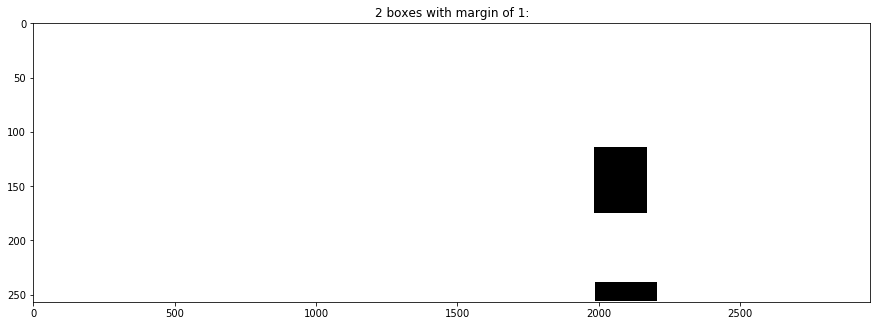

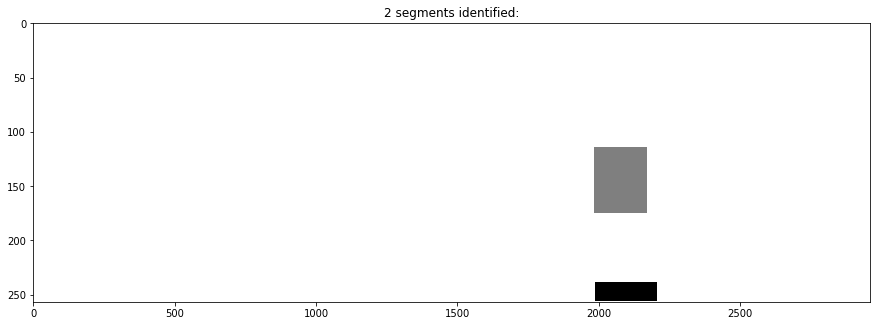

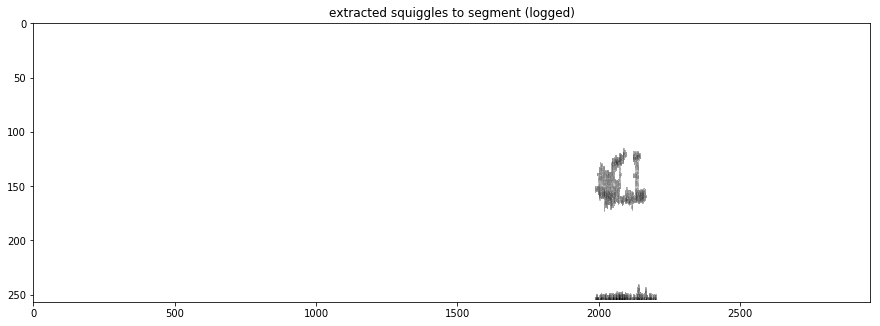

In [27]:
segs = identify_segments(spect_nr, binary_processed_small, bounding_boxes, plot_func=plotter, margin = 1)#, method='min')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Text(0.5,0.98,'segments from /Volumes/seagate3/xeno-canto/20181207/bonasa-umbellus/mp3s/77993.mp3')

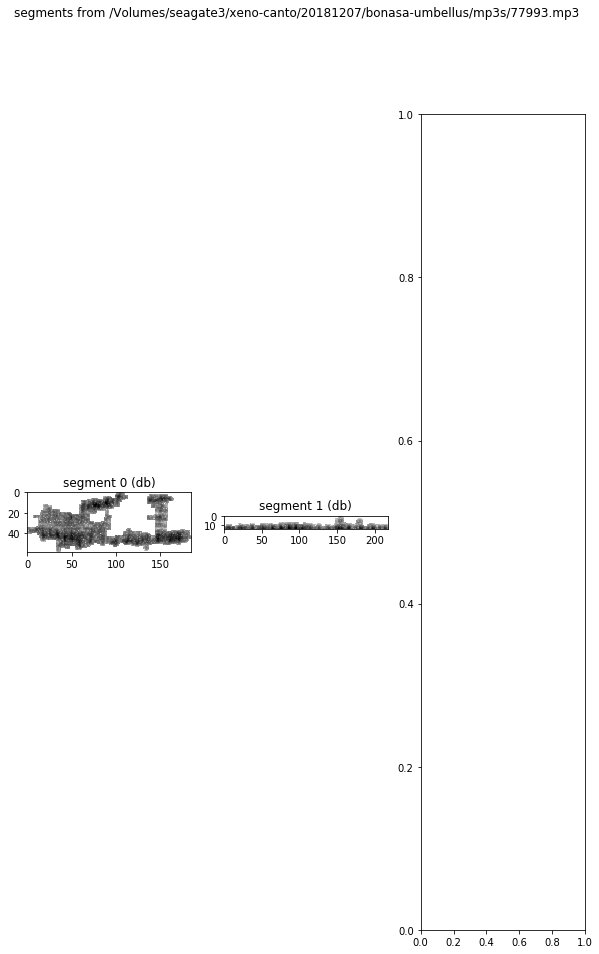

In [28]:
num_segs = len(segs)
num_cols = 3
num_rows = int(np.ceil(num_segs/num_cols))

fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 15))
ordered_axes = []
if num_rows == 1:
    for ax1 in range(ax.shape[0]):
        ordered_axes.append(ax[ax1])
else:
    for ax1 in range(ax.shape[0]):
        for ax2 in range(ax.shape[1]):
            ordered_axes.append(ax[ax1][ax2])
for idx, axis in enumerate(ordered_axes):
    if idx >= len(segs):
        break
    axis.imshow(np.log(cropper(segs[idx])), cmap=plt.get_cmap("gray_r"))
    axis.set_title(f'segment {idx} (db)')
    axis.set_aspect(segs[idx].shape[1] / (10*segs[idx].shape[0]))
fig.subplots_adjust(hspace=0.5)
fig.suptitle(f'segments from {filename}')